In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import random
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Datasets/train.tsv', sep = '\t')
test = pd.read_csv('/content/drive/MyDrive/Datasets/test.tsv', sep = '\t')

def data(n, seed):

    datas = []
    
    random.seed(seed)
    for i in range(n):
        dia_maximo = 30
        dia_minimo = 1
        mes_maximo = 12
        mes_minimo = 1
        
        dia = int(round(random.random() * (dia_maximo - dia_minimo) + dia_minimo, 0))
        mes = int(round(random.random() * (mes_maximo - mes_minimo) + mes_minimo, 0))
        
        datas.append(str(dia)+'-'+str(mes)+'-2018')
        
    return datas

def estoque(n, seed):

    np.random.seed(seed)
    mu, sigma = 1, 20
    s = np.random.normal(mu, sigma, n)
    s[s < 0] = s[s < 0] * -0.5
    s = s.astype(int)
    s[s < 1] = 1
    
    return s

train['date']  = data(n = train.shape[0], seed = 10)
train['stock'] = estoque(n = train.shape[0], seed = 10)

test['date']  = data(n = test.shape[0], seed = 15)
test['stock'] = estoque(n = test.shape[0], seed = 15)

train.drop('train_id', axis=1, inplace=True)
train['item_condition_id'] = train['item_condition_id'].astype('str')

### Objetivo: Entender o comportamento dos dados através de visualizações

Podemos dizer que a variável 'price' é a variável target, ou seja, a variável que devemos prever. Dessa forma, a maior parte desta análise exploratória envolverá esta variável.

In [6]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

train['general_cat'], train['subcat_1'], train['subcat_2'] = zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,date,stock,general_cat,subcat_1,subcat_2
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,18-6-2018,27,Men,Tops,T-shirts
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,18-3-2018,15,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,25-10-2018,14,Women,Tops & Blouses,Blouse
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,20-3-2018,1,Home,Home Décor,Home Décor Accents
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,16-5-2018,13,Women,Jewelry,Necklaces


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  from ipykernel import kernelapp as app


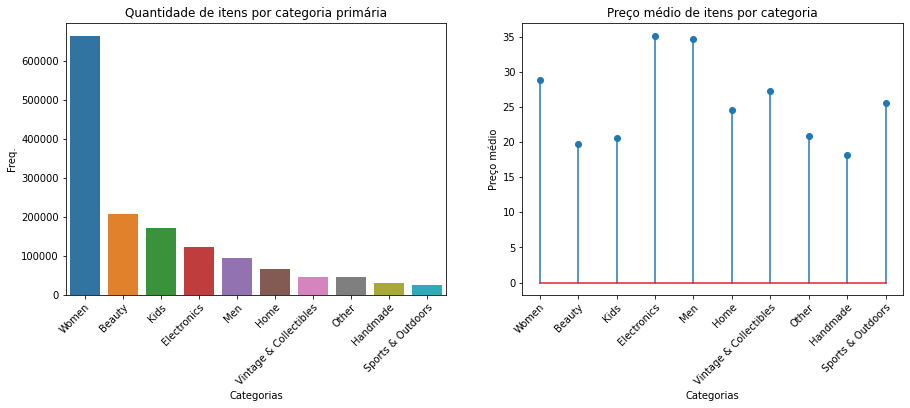

In [7]:
x = train['general_cat'].value_counts().reset_index()

plt.subplots(1, 2, figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(data=x[0:10], x = 'index', y = 'general_cat')
plt.title('Quantidade de itens por categoria primária')
plt.xlabel('Categorias')
plt.ylabel('Freq.')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

x = train[['general_cat','price']].groupby('general_cat').agg(['count','mean']).reset_index().sort_values(by=('price','count'), ascending=False)

plt.subplot(1,2,2)
plt.stem(x['general_cat'][0:10],x[('price','mean')][0:10])
plt.title('Preço médio de itens por categoria')
plt.xlabel('Categorias')
plt.ylabel('Preço médio')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  from ipykernel import kernelapp as app


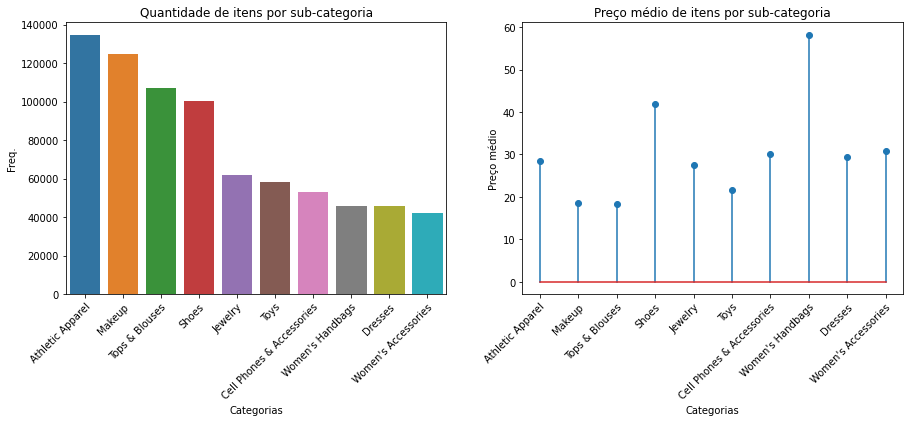

In [8]:
x = train['subcat_1'].value_counts().reset_index()

plt.subplots(1, 2, figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(data=x[0:10], x = 'index', y = 'subcat_1')
plt.xlabel('Categorias')
plt.ylabel('Freq.')
plt.title('Quantidade de itens por sub-categoria')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

x = train[['subcat_1','price']].groupby('subcat_1').agg(['mean','count']).reset_index().sort_values(by=('price','count'), ascending=False)

plt.subplot(1,2,2)
plt.stem(x['subcat_1'][0:10],x[('price','mean')][0:10])
plt.title('Preço médio de itens por sub-categoria')
plt.xlabel('Categorias')
plt.ylabel('Preço médio')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

plt.show()

In [9]:
train['datetime_date'] = pd.to_datetime(train['date'], format = "%d-%m-%Y", errors = 'coerce')
train['datetime_month'] = train['datetime_date'].dt.month

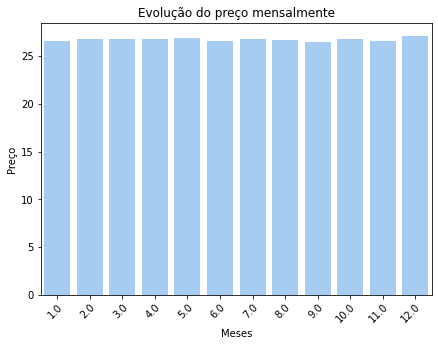

In [10]:
x = train[['general_cat','price', 'datetime_month']].groupby('datetime_month').agg(['count','mean']).reset_index().sort_values(by=('price','count'), ascending=False)

plt.figure(figsize=(7,5))
sns.barplot(data=x, x = 'datetime_month', y = ('price','mean'), color = '#99ccff')
plt.xlabel('Meses')
plt.ylabel('Preço')
plt.title('Evolução do preço mensalmente')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  from ipykernel import kernelapp as app


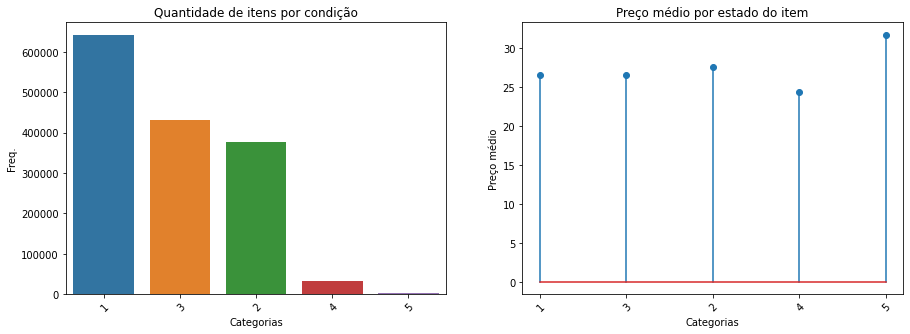

In [12]:
x = train['item_condition_id'].value_counts().reset_index()

plt.subplots(1, 2, figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(data=x, x = 'index', y = 'item_condition_id')
plt.xlabel('Categorias')
plt.ylabel('Freq.')
plt.title('Quantidade de itens por condição')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

x = train[['item_condition_id','price']].groupby('item_condition_id').agg(['mean','count']).reset_index().sort_values(by=('price','count'), ascending=False)

plt.subplot(1,2,2)
plt.stem(x['item_condition_id'],x[('price','mean')])
plt.title('Preço médio por condição')
plt.xlabel('Categorias')
plt.ylabel('Preço médio')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

plt.show()

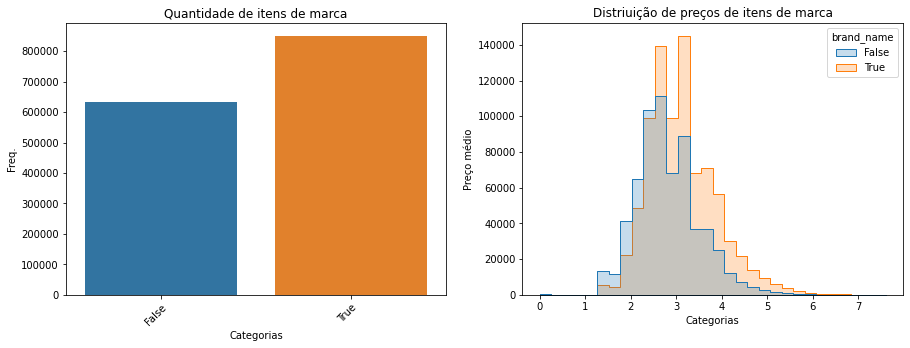

In [51]:
x = (~train['brand_name'].isnull()).value_counts().reset_index()

plt.subplots(1, 2, figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(data=x, x = 'index', y = 'brand_name')
plt.xlabel('Categorias')
plt.ylabel('Freq.')
plt.title('Quantidade de itens de marca')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

# x = pd.concat([(~train['brand_name'].isnull()).astype('str'), train['price']], axis = 1).groupby('brand_name').agg(['mean','count']).reset_index().sort_values(by=('price','count'), ascending=False)

plt.subplot(1,2,2)
sns.histplot(data = train, x = train['price'].apply(lambda x: math.log(x+1)), bins = 30, hue = ~train['brand_name'].isnull(), element="step")
plt.title('Distriuição de preços de itens de marca')
plt.xlabel('Categorias')
plt.ylabel('Preço médio')

plt.show()

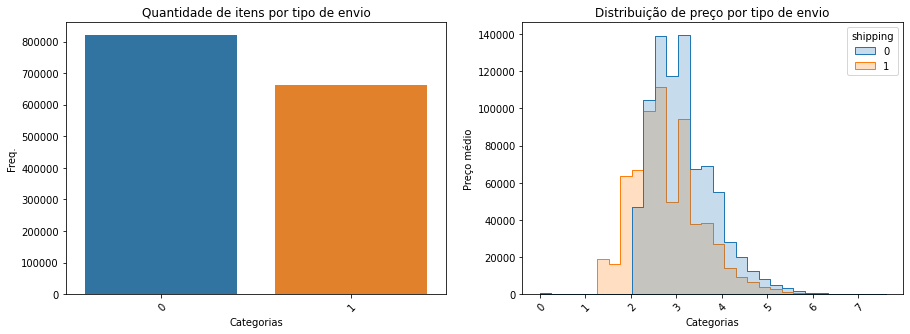

In [55]:
x = train['shipping'].value_counts().reset_index()

plt.subplots(1, 2, figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(data=x, x = 'index', y = 'shipping')
plt.xlabel('Categorias')
plt.ylabel('Freq.')
plt.title('Quantidade de itens por tipo de envio')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

# x = train[['shipping','price']].groupby('shipping').agg(['mean','count']).reset_index().sort_values(by=('price','count'), ascending=False)

plt.subplot(1,2,2)
sns.histplot(x = train['price'].apply(lambda x: math.log(x+1)), bins = 30, hue = train['shipping'], element="step")
plt.title('Distribuição de preço por tipo de envio')
plt.xlabel('Categorias')
plt.ylabel('Preço médio')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

plt.show()

In [11]:
mlb = MultiLabelBinarizer()
mlb.fit(train['general_cat'])
y = mlb.transform(train['general_cat'])
print(y.shape)
y

(1482535, 32)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])